In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras import layers
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_dir = '/content/drive/MyDrive/faceMaskData/'
img_height = img_width = 256
batch_size = 6

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  # batch_size=batch_size,
  labels='inferred',
  label_mode='binary',
  # color_mode to be experimented with later
  color_mode='rgb')

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  # batch_size=batch_size,
  labels='inferred',
  label_mode='binary',
  # color_mode to be experimented with later
  color_mode='rgb')

Found 1378 files belonging to 2 classes.
Using 1103 files for training.
Found 1378 files belonging to 2 classes.
Using 275 files for validation.


In [5]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32, 1)


Sample Images


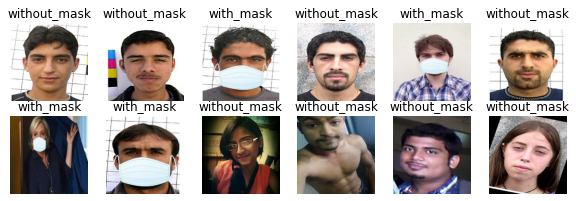

In [6]:
class_names = train_ds.class_names

print("Sample Images")
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(12):
        plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(np.squeeze(labels[i]))])
        plt.axis("off")

In [7]:
# some performance-enhancing code I don't really get
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # caching to have dataset stored in cache for faster access
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) # prefetching our dataset so it's faster

In [8]:
model = tf.keras.models.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # layers.Conv2D(64, 3, padding='same', activation='relu'),
    # layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [9]:
optim = tf.keras.optimizers.Adam() # try tweaking learning rate; lr = 0.001 by default
model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0

In [10]:
num_epochs = 50
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=13)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0003)

history = model.fit(train_ds, epochs=num_epochs, verbose=1, validation_data=val_ds, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
35/35 [==============================] - 7s 73ms/step - loss: 2.9543 - accuracy: 0.5814 - val_loss: 0.3198 - val_accuracy: 0.8945
Epoch 2/50
35/35 [==============================] - 1s 37ms/step - loss: 0.1925 - accuracy: 0.9444 - val_loss: 0.1168 - val_accuracy: 0.9491
Epoch 3/50
35/35 [==============================] - 1s 36ms/step - loss: 0.0908 - accuracy: 0.9695 - val_loss: 0.0815 - val_accuracy: 0.9564
Epoch 4/50
35/35 [==============================] - 1s 36ms/step - loss: 0.0481 - accuracy: 0.9860 - val_loss: 0.0952 - val_accuracy: 0.9636
Epoch 5/50
35/35 [==============================] - 1s 36ms/step - loss: 0.0303 - accuracy: 0.9869 - val_loss: 0.0961 - val_accuracy: 0.9600
Epoch 6/50
35/35 [==============================] - 1s 36ms/step - loss: 0.0303 - accuracy: 0.9911 - val_loss: 0.0980 - val_accuracy: 0.9709
Epoch 7/50
35/35 [==============================] - 1s 36ms/step - loss: 0.0210 - accuracy: 0.9964 - val_loss: 0.0908 - val_accuracy: 0.9636
Epoch 8/50
35

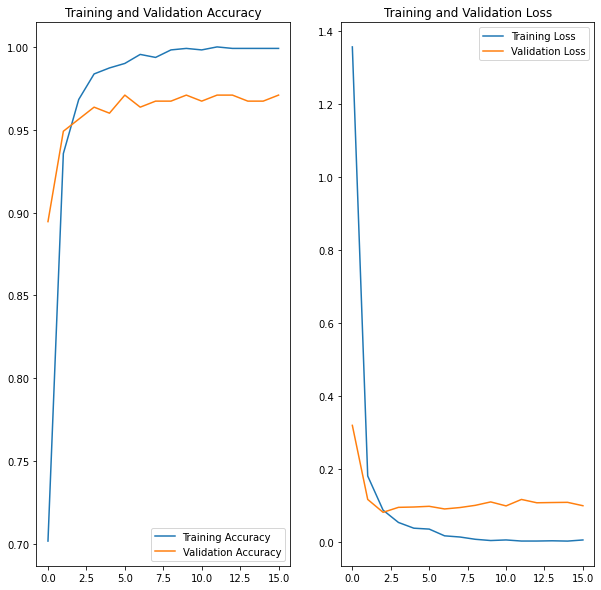

In [11]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

== Our Prediction ==
This person is wearing a mask!


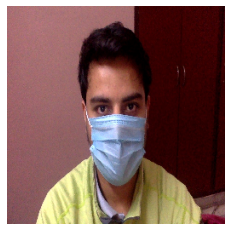

In [12]:
mask_imgpath = '/content/drive/MyDrive/faceMaskData/with_mask/adityaMask.jpg'
no_mask_imgpath = '/content/drive/MyDrive/faceMaskData/without_mask/adityaNoMask.jpg'

img = load_img(
    mask_imgpath, target_size=(img_height, img_width)
)

img_array = tf.expand_dims(img_to_array(img), 0)
prediction = np.squeeze(model.predict(img_array))

plt.imshow(img)
plt.axis('off')

print("== Our Prediction ==")
if prediction < 0.5:
    print("This person is wearing a mask!")
else:
    print("This person is maskless!")

In [13]:
model.save('/content/model.h5', overwrite=True)